In [30]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from datetime import date, datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('prices_predict.csv', parse_dates=['begin', 'end'], sep=';')

In [171]:
data = df.copy()

In [172]:
data['day'] = data['begin'].dt.day
data['month'] = data['begin'].dt.month
data['year'] = data['begin'].dt.year

In [173]:
data['next'] = data['begin'] + pd.DateOffset(1)

In [174]:
data = data.merge(data[['begin','symbol','close']].rename(columns={'close':'next_close'}), how='left',
              left_on=['symbol', 'next'], right_on=['symbol', 'begin'])

In [175]:
data['ch_close'] = data['next_close'] - data['close']

In [176]:
data['target'] = np.where(data['ch_close'] > 0, 1, 0)

In [177]:
data.dropna(inplace=True)

target_1 - prediction LSTM

target_2 - prediction GRU

target_3 - prediction ResNet

In [202]:
features = data[['target_1','target_2','target_3']]
target = data['target']

scaler = StandardScaler()
features = scaler.fit_transform(features)

X_train, X_valid, Y_train, Y_valid = train_test_split(
    features, target, test_size=0.1, random_state=2022)
print(X_train.shape, X_valid.shape)

(7838, 3) (871, 3)


In [203]:
model=CatBoostClassifier(
     iterations= 1200,
    l2_leaf_reg = 10,
    depth = 3,
    loss_function = 'Logloss',
    # use_best_model = True,
     verbose=False,
   random_seed = 42)


model.fit(X_train, Y_train)


In [181]:
predict_y = model.predict(X_valid)
print('Validation ROC AUC : ', metrics.roc_auc_score(Y_valid, model.predict_proba(X_valid)[:,1]))
print('Validation Accuracy : ', metrics.accuracy_score(Y_valid, predict_y))
print('Validation Precision : ', metrics.precision_score(Y_valid,predict_y))
print('Validation Recall : ', metrics.recall_score(Y_valid, predict_y))

Validation ROC AUC :  0.8376826050582407
Validation Accuracy :  0.7784156142365097
Validation Precision :  0.7325
Validation Recall :  0.7730870712401056


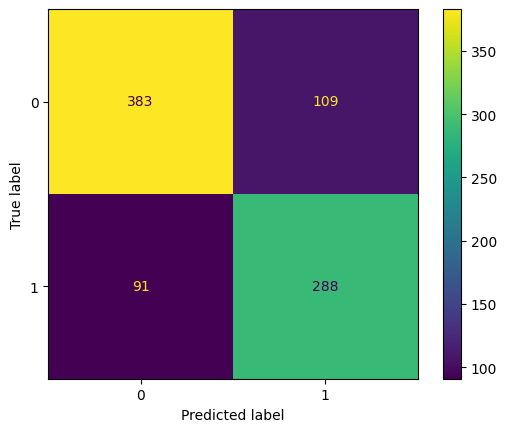

In [191]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp=ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(Y_valid, predict_y))
disp.plot()

In [208]:
feature_importance = pd.DataFrame(columns = ['feature_name', 'feature_importance'])
feature_importance['feature_name'] = ['target_1','target_2','target_3']
feature_importance['feature_importance'] = model.feature_importances_
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance.sort_values(by='feature_importance', ascending=False))

  feature_name  feature_importance
2     target_3           45.409166
0     target_1           34.618791
1     target_2           20.972043
